In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from keras.layers import Input, Dense, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import sklearn.utils.class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
import random
np.random.seed(42)
import xgboost as xgb
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 7)


# READING DATA

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classes = pd.read_table('/content/drive/My Drive/doan1/data/profile.txt', header=None)

In [ ]:
classes.columns = ['cooler', 'valve', 'pump', 'accumulator' , 'flag'] 


In [ ]:
cooler = pd.get_dummies(classes['cooler'])
valve = pd.get_dummies(classes['valve'])
pump = pd.get_dummies(classes['pump'])
accumulator = pd.get_dummies(classes['accumulator'])
flag = pd.get_dummies(classes['flag'])


In [ ]:

dir_path = '/content/drive/My Drive/doan1/data'
file_list = os.listdir(dir_path)


In [ ]:
file_list

['EPS1.txt',
 'FS1.txt',
 'FS2.txt',
 'CE.txt',
 'CP.txt',
 'PS1.txt',
 'PS2.txt',
 'PS3.txt',
 'PS4.txt',
 'PS5.txt',
 'PS6.txt',
 'SE.txt',
 'TS1.txt',
 'TS2.txt',
 'TS3.txt',
 'TS4.txt',
 'VS1.txt',
 'profile.txt',
 'documentation.txt',
 'description.txt']

In [ ]:
text_files = [file for file in file_list if file not in ['profile.txt','description.txt','documentation.txt']]


In [ ]:

text_files

['EPS1.txt',
 'FS1.txt',
 'FS2.txt',
 'CE.txt',
 'CP.txt',
 'PS1.txt',
 'PS2.txt',
 'PS3.txt',
 'PS4.txt',
 'PS5.txt',
 'PS6.txt',
 'SE.txt',
 'TS1.txt',
 'TS2.txt',
 'TS3.txt',
 'TS4.txt',
 'VS1.txt']

# UPSAMPLING TECHNIQUE 

In [ ]:
TS1 = pd.read_table('/content/drive/My Drive/doan1/data/TS1.txt', header=None)

In [ ]:

#This code implement upsampling time series data with goals up to 100hz sampling rate
def resample_row(row):
    target_num_points = 6000
    num_points = len(row)

    resampled_row = np.interp(np.linspace(0, num_points-1, target_num_points), np.arange(num_points), row)
    return pd.Series(resampled_row)



In [ ]:
resampled_data = TS1.apply(resample_row, axis=1)

In [ ]:

TS1 = pd.read_table('/content/drive/My Drive/doan1/data/TS1.txt', header=None)

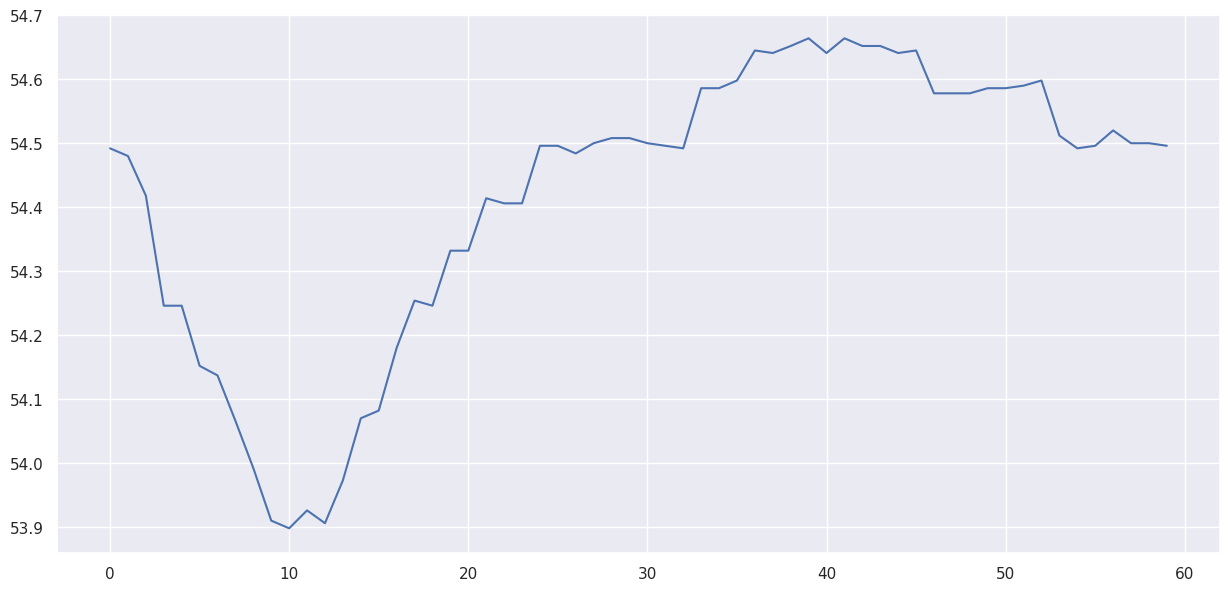

In [ ]:
plt.plot(TS1.iloc[250].T);


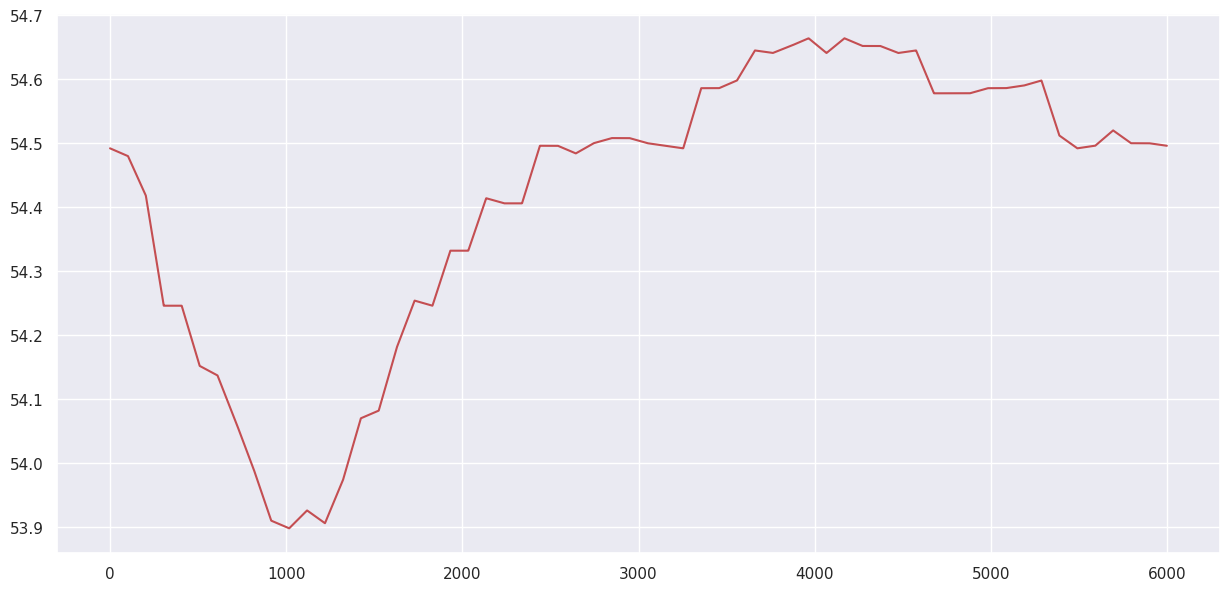

In [ ]:
plt.plot(resampled_data.iloc[250].T,'r');

In [ ]:
def data_processing_resampling():
    dfs = {}
    up_list = ['FS1' ,'FS2','TS1','TS2','TS3','TS4','VS1','CE','CP','SE']
    for file in text_files:
        file_path = os.path.join(dir_path, file)
        df = pd.read_table(file_path,header=None)
        feature = file.rstrip('.txt')
        if feature in up_list:
            df = df.apply(resample_row, axis=1)
        dfs[feature] = df
    return dfs
  

In [ ]:

trainning_data_dict = data_processing_resampling()


In [ ]:
def data_processing_handle_missing(trainning_data_dict):
    for df in trainning_data_dict:
      null_counts = trainning_data_dict[df].isna().sum()
      check_feature_null = null_counts[null_counts > 1].index.tolist()
      check_feature_null
      trainning_data_dict[df][check_feature_null] = trainning_data_dict[df][check_feature_null].fillna(0)
      scaler = StandardScaler()
      trainning_data_dict[df] = scaler.fit_transform(trainning_data_dict[df])
      return trainning_data_dict

In [ ]:
trainning_data_dict = data_processing_handle_missing(trainning_data_dict)

# MULTI-HEAD-CHANNEL-1D CONV


In [ ]:
data_1 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['VS1','EPS1']])
data_2 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['PS1','PS2','TS1','FS1','PS3','TS2']])
data_3 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['PS4','PS5','TS3','PS6','TS4','FS2']])
data_4 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['CE','CP','SE']])
#Concating data in shape(time_step, feature) Each feature represent a sensor

In [ ]:
from keras.layers import Input, Dense, Flatten, concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Define input shapes
input1_shape = (6000, 2) #all sensors placed near pump and accumulator
input2_shape = (6000, 6) #all sensors placed arround valve
input3_shape = (6000, 6) #all sensors arround cooler 
input4_shape = (6000, 3) #all virtual sensors


# Define input layers
input1 = Input(shape=input1_shape)
input2 = Input(shape=input2_shape)
input3 = Input(shape=input3_shape)
input4 = Input(shape=input4_shape)

# First convolutional layer for input1
conv1_1 = Conv1D(filters=32, kernel_size=100,strides=2,activation='relu')(input1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool1_1)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
flat1 = Flatten()(pool1_2)

# Second convolutional layer for input2
conv2_1 = Conv1D(filters=32, kernel_size=100,strides=2, activation='relu')(input2)
pool2_1 = MaxPooling1D(pool_size=2)(conv2_1)
conv2_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool2_1)
pool2_2 = MaxPooling1D(pool_size=2)(conv2_2)
flat2 = Flatten()(pool2_2)
# Second convolutional layer for input3
conv3_1 = Conv1D(filters=32, kernel_size=100,strides=2, activation='relu')(input3)
pool3_1 = MaxPooling1D(pool_size=2)(conv3_1)
conv3_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool3_1)
pool3_2 = MaxPooling1D(pool_size=2)(conv3_2)
flat3 = Flatten()(pool3_2)
# Second convolutional layer for input4
conv4_1 = Conv1D(filters=32, kernel_size=100,strides=2, activation='relu')(input4)
pool4_1 = MaxPooling1D(pool_size=2)(conv4_1)
conv4_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool4_1)
pool4_2 = MaxPooling1D(pool_size=2)(conv4_2)
flat4 = Flatten()(pool4_2)
# Merge input channels
merged = concatenate([flat1, flat2,flat3,flat4])

# Define output layers
dense1 = Dense(512, activation='relu')(merged)
dense2 = Dense(64, activation='relu')(dense1)

output_1 = Dense(4, activation='softmax')(dense2)
output_2 = Dense(3, activation='softmax')(dense2)
output_3 = Dense(4, activation='softmax')(dense2)
output_4 = Dense(3, activation='softmax')(dense2)
output_5 = Dense(2, activation='softmax')(dense2)

# Define the model
model_1 = Model(inputs=[input1, input2, input3, input4], outputs=output_1) #accumulator 
model_2 = Model(inputs=[input1, input2, input3, input4], outputs=output_2)#pump
model_3 = Model(inputs=[input1, input2, input3, input4], outputs=output_3)#valve
model_4 = Model(inputs=[input1, input2, input3, input4], outputs=output_4)#cooler
model_5 = Model(inputs=[input1, input2, input3, input4], outputs=output_5)#flag

# Compile the model

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
def f1_macro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_macro = K.mean(2*((precision*recall)/(precision+recall+K.epsilon())))
    return f1_macro
filepath_1 = '/content/drive/My Drive/doan1/weights_cnn/accumulators.hdf5'
filepath_2 = '/content/drive/My Drive/doan1/weights_cnn/pump.hdf5'
filepath_3 = '/content/drive/My Drive/doan1/weights_cnn/valve.hdf5'
filepath_4 = '/content/drive/My Drive/doan1/weights_cnn/cooler.hdf5'
filepath_5 = '/content/drive/My Drive/doan1/weights_cnn/flag.hdf5'
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_2 = ModelCheckpoint(filepath_2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_3 = ModelCheckpoint(filepath_3, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_4 = ModelCheckpoint(filepath_4, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_5 = ModelCheckpoint(filepath_5, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])




ACCUMULATOR 

In [ ]:
X_train1_accumulator, X_val1_accumulator, y_train1_accumulator, y_val1_accumulator = train_test_split(data_1, accumulator, test_size=0.2, random_state=42, stratify=accumulator)
X_train2_accumulator, X_val2_accumulator, y_train2_accumulator,  y_val2_accumulator = train_test_split(data_2, accumulator, test_size=0.2, random_state=42, stratify=accumulator)
X_train3_accumulator, X_val3_accumulator, y_train3_accumulator,  y_val3_accumulator = train_test_split(data_3, accumulator, test_size=0.2, random_state=42, stratify=accumulator)
X_train4_accumulator, X_val4_accumulator, y_train4_accumulator , y_val4_accumulator = train_test_split(data_4, accumulator, test_size=0.2, random_state=42, stratify=accumulator)

In [ ]:
model_1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 6000, 2)]    0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 6000, 6)]    0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 6000, 6)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 6000, 3)]    0           []                               
                                                                                           

In [ ]:
history = model_1.fit([X_train1_accumulator, X_train2_accumulator,  X_train3_accumulator, X_train4_accumulator], y_train1_accumulator, epochs=50, callbacks=[checkpoint_1],batch_size=32,validation_data=([X_val1_accumulator, X_val2_accumulator, X_val3_accumulator, X_val4_accumulator], y_val1_accumulator))
# Train the model


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 42.6818 - accuracy: 0.3277 - f1_macro: 0.0612
Epoch 1: val_loss improved from inf to 3.61034, saving model to /content/drive/My Drive/doan1/weights_cnn/accumulators.hdf5
56/56 [==============================] - 22s 344ms/step - loss: 42.6818 - accuracy: 0.3277 - f1_macro: 0.0612 - val_loss: 3.6103 - val_accuracy: 0.3651 - val_f1_macro: 0.1316
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 1.3698 - accuracy: 0.3991 - f1_macro: 0.0660
Epoch 2: val_loss improved from 3.61034 to 1.25921, saving model to /content/drive/My Drive/doan1/weights_cnn/accumulators.hdf5
56/56 [==============================] - 16s 287ms/step - loss: 1.3698 - accuracy: 0.3991 - f1_macro: 0.0660 - val_loss: 1.2592 - val_accuracy: 0.3878 - val_f1_macro: 0.1532
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 1.1618 - accuracy: 0.5023 - f1_macro: 0.2397
Epoch 3: val_loss did not improve from 1.25921
56/56 [=====

In [ ]:
#y_pred = model_1.predict([X_val1, X_val2, X_val3, X_val4])


14/14 [==============================] - 0s 5ms/step


In [ ]:
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)


PUMP

In [ ]:
X_train1_pump, X_val1_pump, y_train1_pump, y_val1_pump = train_test_split(data_1, pump, test_size=0.2, random_state=42, stratify=pump)
X_train2_pump, X_val2_pump, y_train2_pump,  y_val2_pump = train_test_split(data_2, pump, test_size=0.2, random_state=42, stratify=pump)
X_train3_pump, X_val3_pump, y_train3_pump,  y_val3_pump = train_test_split(data_3, pump, test_size=0.2, random_state=42, stratify=pump)
X_train4_pump, X_val4_pump, y_train4_pump,  y_val4_pump = train_test_split(data_4, pump, test_size=0.2, random_state=42, stratify=pump)

In [ ]:
history_2 = model_2.fit([X_train1_pump, X_train2_pump,  X_train3_pump, X_train4_pump], y_train1_pump, epochs=30, batch_size=32,callbacks=[checkpoint_2],validation_data=([X_val1_pump, X_val2_pump, X_val3_pump, X_val4_pump], y_val1_pump))


Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.7137 - f1_macro: 0.6198
Epoch 1: val_loss improved from inf to 0.35573, saving model to /content/drive/My Drive/doan1/weights_cnn/pump.hdf5
56/56 [==============================] - 46s 823ms/step - loss: 0.8800 - accuracy: 0.7137 - f1_macro: 0.6198 - val_loss: 0.3557 - val_accuracy: 0.8821 - val_f1_macro: 0.8406
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8951 - f1_macro: 0.8579
Epoch 2: val_loss improved from 0.35573 to 0.28077, saving model to /content/drive/My Drive/doan1/weights_cnn/pump.hdf5
56/56 [==============================] - 16s 292ms/step - loss: 0.2954 - accuracy: 0.8951 - f1_macro: 0.8579 - val_loss: 0.2808 - val_accuracy: 0.9048 - val_f1_macro: 0.8811
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9212 - f1_macro: 0.8916
Epoch 3: val_loss improved from 0.28077 to 0.22338, saving model to /content/

In [ ]:
# y_pred = model_2.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)
  

VALVE

In [ ]:
X_train1_valve, X_val1_valve, y_train1_valve, y_val1_valve = train_test_split(data_1, valve, test_size=0.2, random_state=42, stratify=valve)
X_train2_valve, X_val2_valve, y_train2_valve,  y_val2_valve = train_test_split(data_2, valve, test_size=0.2, random_state=42, stratify=valve)
X_train3_valve, X_val3_valve, y_train3_valve,  y_val3_valve = train_test_split(data_3, valve, test_size=0.2, random_state=42, stratify=valve)
X_train4_valve, X_val4_valve, y_train4_valve,  y_val4_valve = train_test_split(data_4, valve, test_size=0.2, random_state=42, stratify=valve)

In [ ]:
history_3 = model_3.fit([X_train1_valve, X_train2_valve,  X_train3_valve, X_train4_valve], y_train1_valve, epochs=30,callbacks=[checkpoint_3], batch_size=32,validation_data=([X_val1_valve, X_val2_valve, X_val3_valve, X_val4_valve], y_val1_valve))


Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.7115 - f1_macro: 0.5462
Epoch 1: val_loss improved from inf to 0.16889, saving model to /content/drive/My Drive/doan1/weights_cnn/valve.hdf5
56/56 [==============================] - 22s 354ms/step - loss: 1.0296 - accuracy: 0.7115 - f1_macro: 0.5462 - val_loss: 0.1689 - val_accuracy: 0.9592 - val_f1_macro: 0.9457
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9643 - f1_macro: 0.9349
Epoch 2: val_loss improved from 0.16889 to 0.07207, saving model to /content/drive/My Drive/doan1/weights_cnn/valve.hdf5
56/56 [==============================] - 16s 293ms/step - loss: 0.0967 - accuracy: 0.9643 - f1_macro: 0.9349 - val_loss: 0.0721 - val_accuracy: 0.9819 - val_f1_macro: 0.9746
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9921 - f1_macro: 0.9794
Epoch 3: val_loss improved from 0.07207 to 0.04077, saving model to /conten

In [ ]:
# y_pred = model_3.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)

COOLER

In [ ]:
X_train1_cooler, X_val1_cooler, y_train1_cooler, y_val1_cooler = train_test_split(data_1, cooler, test_size=0.2, random_state=42, stratify=cooler)
X_train2_cooler, X_val2_cooler, y_train2_cooler,  y_val2_cooler = train_test_split(data_2, cooler, test_size=0.2, random_state=42, stratify=cooler)
X_train3_cooler, X_val3_cooler, y_train3_cooler,  y_val3_cooler = train_test_split(data_3, cooler, test_size=0.2, random_state=42, stratify=cooler)
X_train4_cooler, X_val4_cooler, y_train4_cooler,  y_val4_cooler = train_test_split(data_4, cooler, test_size=0.2, random_state=42, stratify=cooler)

In [ ]:
history_4 = model_4.fit([X_train1_cooler, X_train2_cooler,  X_train3_cooler, X_train4_cooler], y_train1_cooler, epochs=30, batch_size=32,callbacks=[checkpoint_4],validation_data=([X_val1_cooler, X_val2_cooler, X_val3_cooler, X_val4_cooler], y_val1_cooler))


Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.9376 - f1_macro: 0.9312
Epoch 1: val_loss improved from inf to 0.11730, saving model to /content/drive/My Drive/doan1/weights_cnn/cooler.hdf5
56/56 [==============================] - 24s 388ms/step - loss: 0.5119 - accuracy: 0.9376 - f1_macro: 0.9312 - val_loss: 0.1173 - val_accuracy: 0.9796 - val_f1_macro: 0.9768
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9898 - f1_macro: 0.9901
Epoch 2: val_loss improved from 0.11730 to 0.11135, saving model to /content/drive/My Drive/doan1/weights_cnn/cooler.hdf5
56/56 [==============================] - 17s 295ms/step - loss: 0.0630 - accuracy: 0.9898 - f1_macro: 0.9901 - val_loss: 0.1113 - val_accuracy: 0.9773 - val_f1_macro: 0.9760
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9921 - f1_macro: 0.9854
Epoch 3: val_loss improved from 0.11135 to 0.05604, saving model to /cont

In [ ]:
# y_pred = model_4.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)

FLAG

In [ ]:
X_train1_flag, X_val1_flag, y_train1_flag, y_val1_flag = train_test_split(data_1, flag, test_size=0.2, random_state=42, stratify=flag)
X_train2_flag, X_val2_flag, y_train2_flag,  y_val2_flag = train_test_split(data_2, flag, test_size=0.2, random_state=42, stratify=flag)
X_train3_flag, X_val3_flag, y_train3_flag,  y_val3_flag = train_test_split(data_3, flag, test_size=0.2, random_state=42, stratify=flag)
X_train4_flag, X_val4_flag, y_train4_flag,  y_val4_flag = train_test_split(data_4, flag, test_size=0.2, random_state=42, stratify=flag)

In [ ]:
history_5 = model_5.fit([X_train1_flag, X_train2_flag,  X_train3_flag, X_train4_flag], y_train1_flag, epochs=20, callbacks=[checkpoint_5],batch_size=32,validation_data=([X_val1_flag, X_val2_flag, X_val3_flag, X_val4_flag], y_val1_flag))


Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.8906 - f1_macro: 0.8677
Epoch 1: val_loss improved from inf to 0.15489, saving model to /content/drive/My Drive/doan1/weights_cnn/flag.hdf5
56/56 [==============================] - 26s 419ms/step - loss: 0.7657 - accuracy: 0.8906 - f1_macro: 0.8677 - val_loss: 0.1549 - val_accuracy: 0.9229 - val_f1_macro: 0.9085
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9422 - f1_macro: 0.9346
Epoch 2: val_loss improved from 0.15489 to 0.15211, saving model to /content/drive/My Drive/doan1/weights_cnn/flag.hdf5
56/56 [==============================] - 17s 306ms/step - loss: 0.1571 - accuracy: 0.9422 - f1_macro: 0.9346 - val_loss: 0.1521 - val_accuracy: 0.9184 - val_f1_macro: 0.9058
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9490 - f1_macro: 0.9424
Epoch 3: val_loss improved from 0.15211 to 0.13583, saving model to /content/

In [ ]:

# y_pred = model_5.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)

SUMMARY

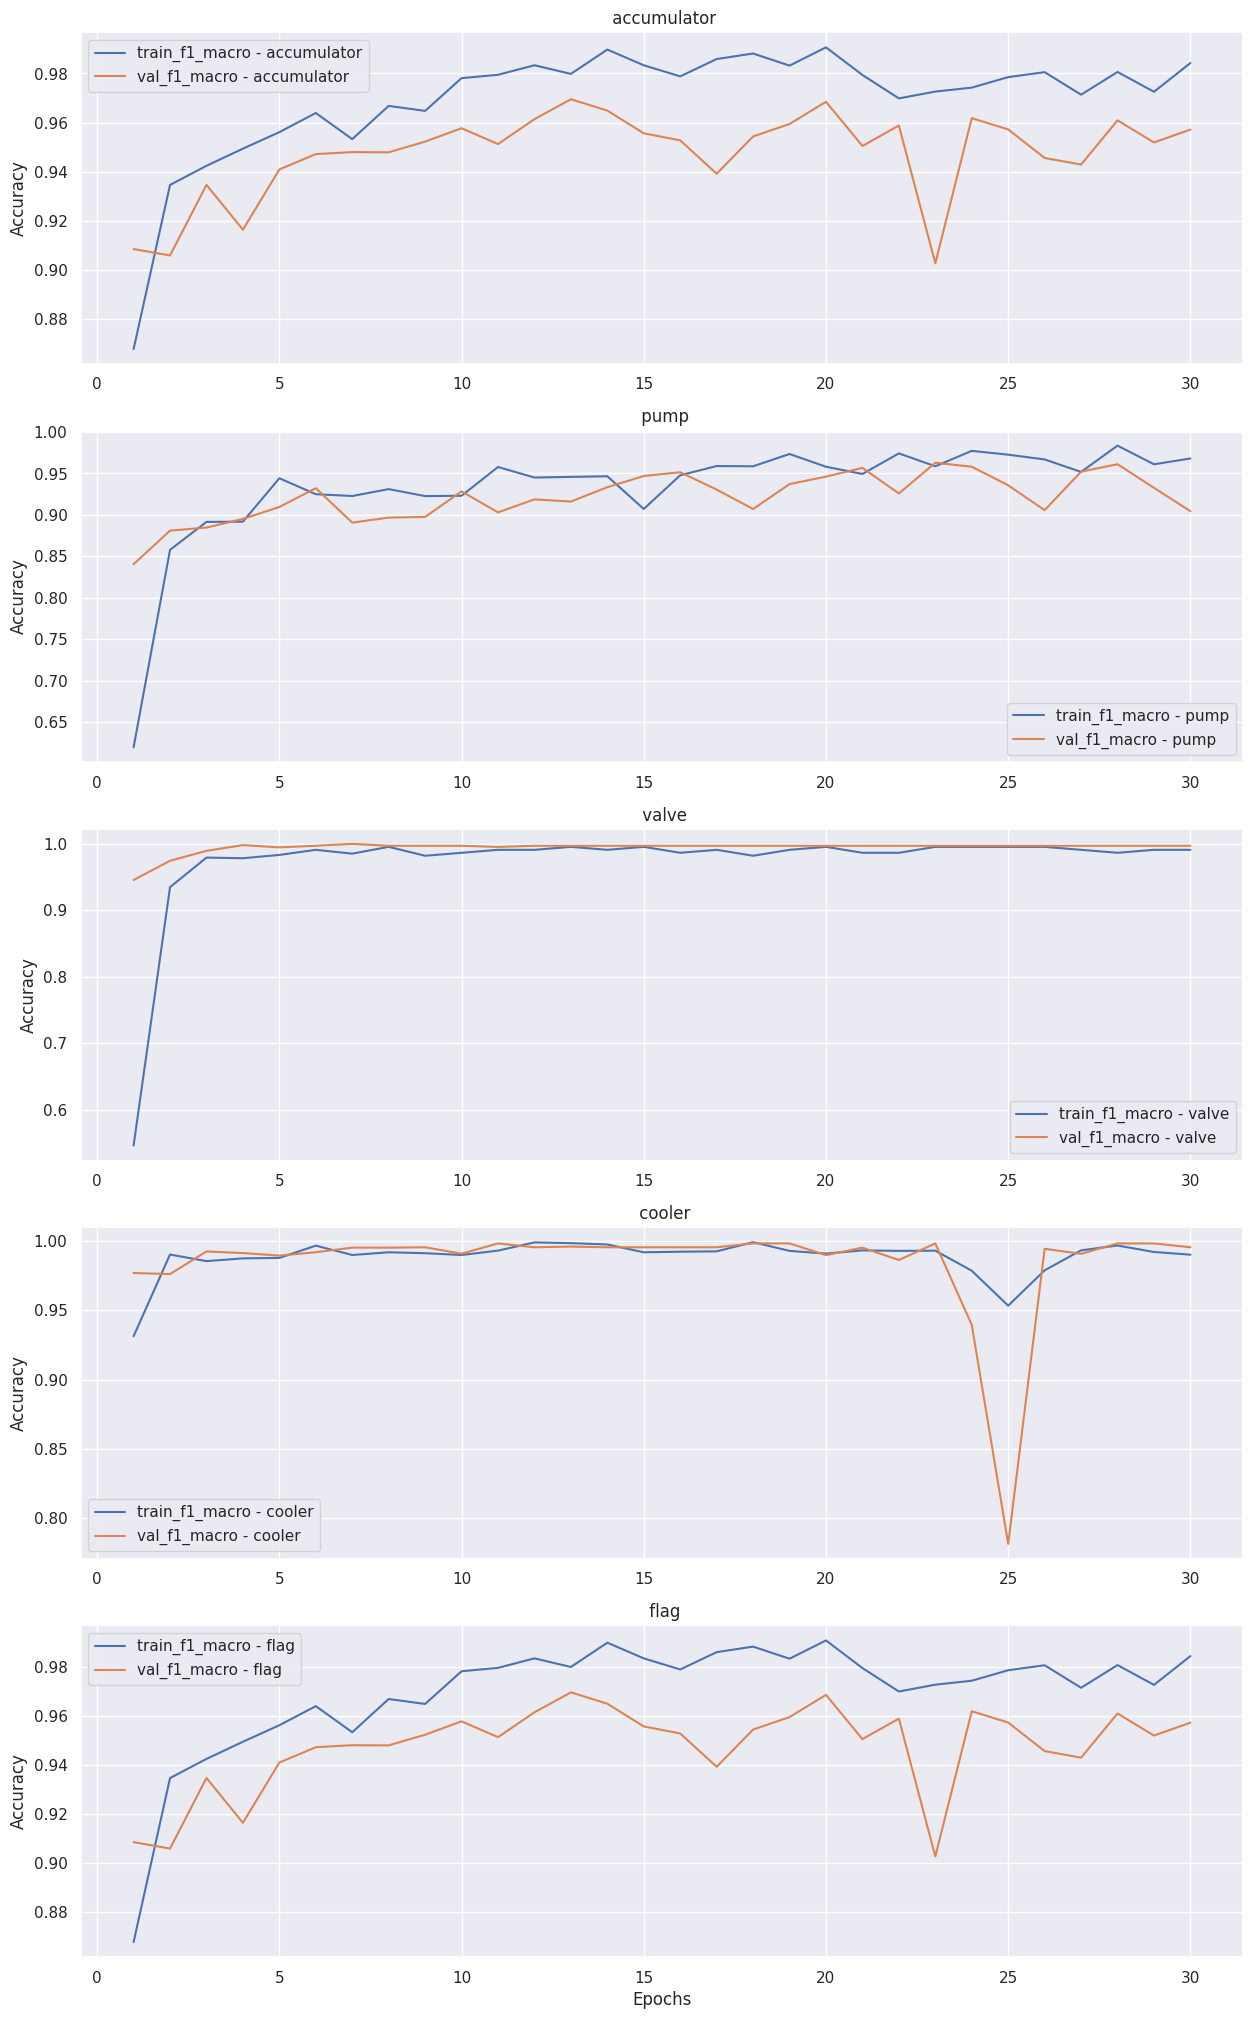

In [ ]:
epochs = range(1, len(history.history['f1_macro']) + 1)
fig, axs = plt.subplots(5, 1, figsize=(15, 25))
for i, history in enumerate([history, history_2, history_3, history_4, history_5]):
    train_acc = history.history['f1_macro']
    val_acc = history.history['val_f1_macro']
    axs[i].plot(epochs, train_acc, label=f'train_f1_macro - {["accumulator", "pump", "valve", "cooler", "flag"][i]}')
    axs[i].plot(epochs, val_acc, label=f'val_f1_macro - {["accumulator", "pump", "valve", "cooler", "flag"][i]}')
    axs[i].set_title(f' {["accumulator", "pump", "valve", "cooler", "flag"][i]}')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()
axs[i].set_xlabel('Epochs')

plt.show()

In [ ]:
# Load the trained weights for each model
model_1.load_weights('/content/drive/My Drive/doan1/weights_cnn/accumulators.hdf5')
output_1 = model_1.predict([X_val1_accumulator, X_val2_accumulator, X_val3_accumulator, X_val4_accumulator])
model_2.load_weights('/content/drive/My Drive/doan1/weights_cnn/pump.hdf5')
output_2 = model_2.predict([X_val1_pump, X_val2_pump, X_val3_pump, X_val4_pump])
model_3.load_weights('/content/drive/My Drive/doan1/weights_cnn/valve.hdf5')
output_3 = model_3.predict([X_val1_valve, X_val2_valve, X_val3_valve, X_val4_valve])
model_4.load_weights('/content/drive/My Drive/doan1/weights_cnn/cooler.hdf5')
output_4 = model_4.predict([X_val1_cooler, X_val2_cooler, X_val3_cooler, X_val4_cooler])
model_5.load_weights('/content/drive/My Drive/doan1/weights_cnn/flag.hdf5')
output_5 = model_5.predict([X_val1_flag, X_val2_flag, X_val3_flag, X_val4_flag])


14/14 [==============================] - 1s 39ms/step


In [ ]:
y_pred = [output_1,output_2,output_3,output_4,output_5]

In [ ]:
y_true = [y_val1_accumulator, y_val1_pump,y_val1_valve,y_val1_cooler,y_val1_flag]

In [ ]:
def draw_confusion(y_true, y_pred, labels, label, color):
    predict = np.argmax(y_pred, axis=1)
    true = np.argmax(y_true.values, axis=1)
    cm = confusion_matrix(true, predict)
    # Plot confusion matrix
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(label)
    plt.show()


DOWN-SAMPLING TECHNIQUE

In [ ]:
accumulator_labels = ['close to total failure', 'severely reduced pressure','slightly reduced pressure','optimal pressure']
pump_labels = ['no leakage', 'weak leakage', 'severe leakage']
valve_labels = ['close to total failure','severe lag', 'small lag', 'optimal switching behavior']
cooler_labels = ['close to total failure', 'reduced effifiency', 'full efficiency']
flag_labels = ['stable condition', 'unstable condition']
predict_labels = [accumulator_labels, pump_labels, valve_labels, cooler_labels,flag_labels]
labels = ['accumulator', 'pump', 'valve', 'cooler','flag']
colors = ['Blues', 'Greens', 'Reds', 'PuRd', 'YlOrBr']


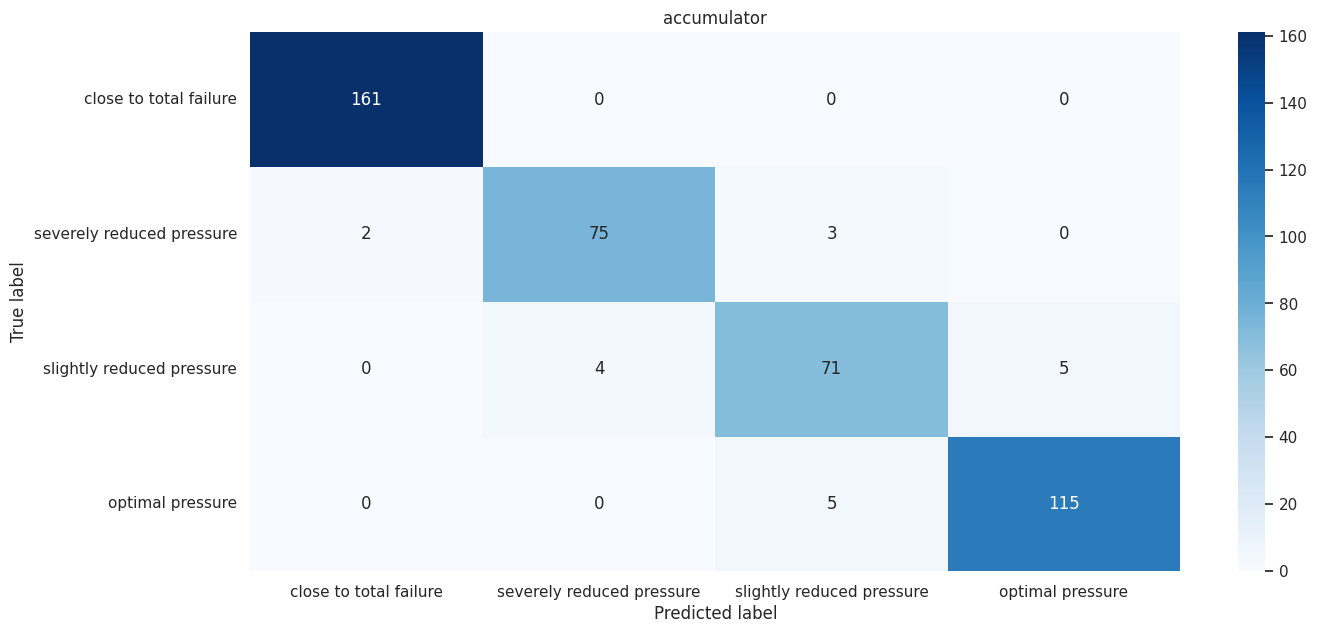

In [ ]:
draw_confusion(y_true[0],y_pred[0],predict_labels[0],labels[0], colors[0])


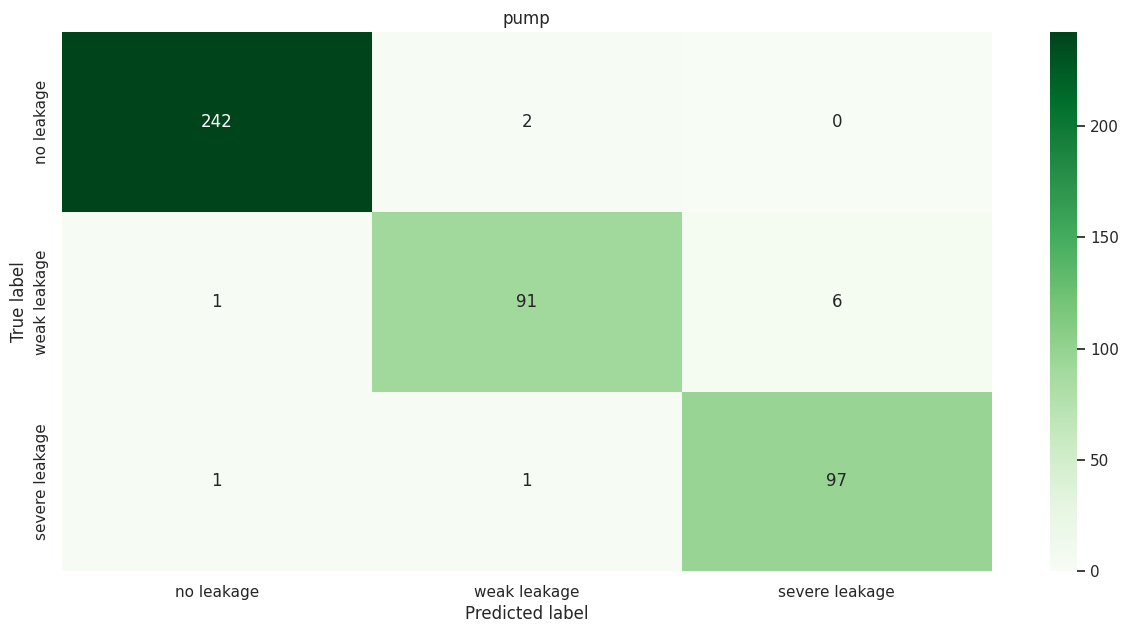

In [ ]:
draw_confusion(y_true[1],y_pred[1],predict_labels[1],labels[1], colors[1])


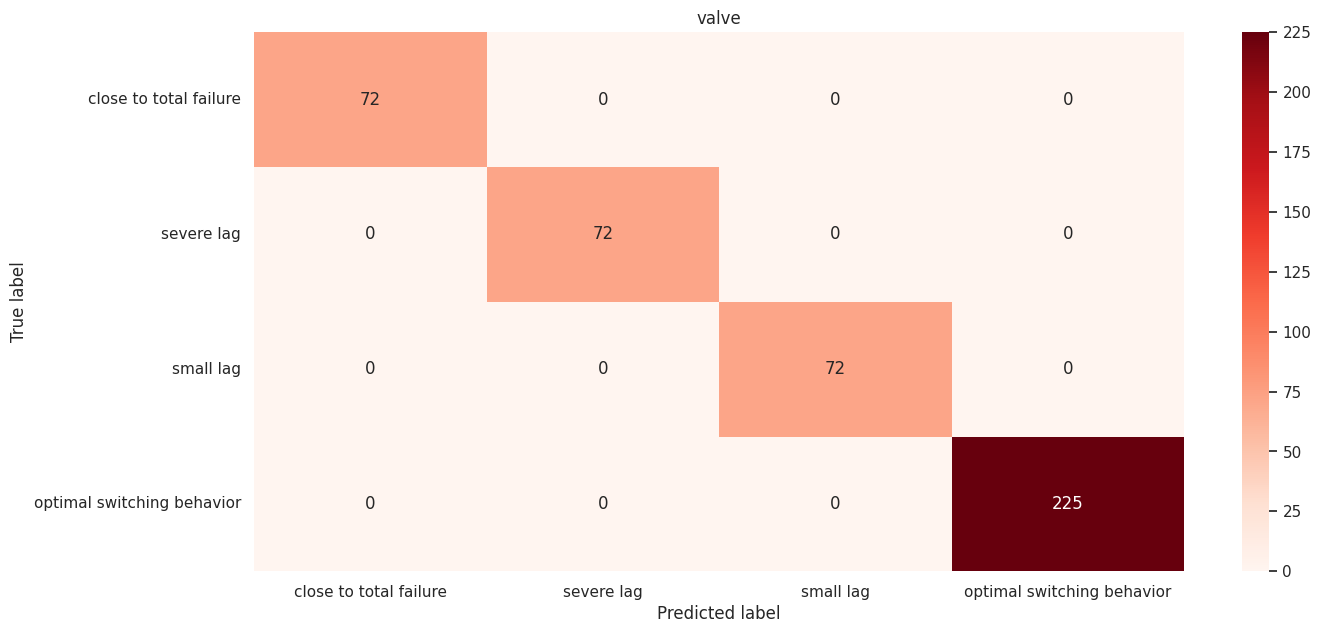

In [ ]:
draw_confusion(y_true[2],y_pred[2],predict_labels[2],labels[2], colors[2])


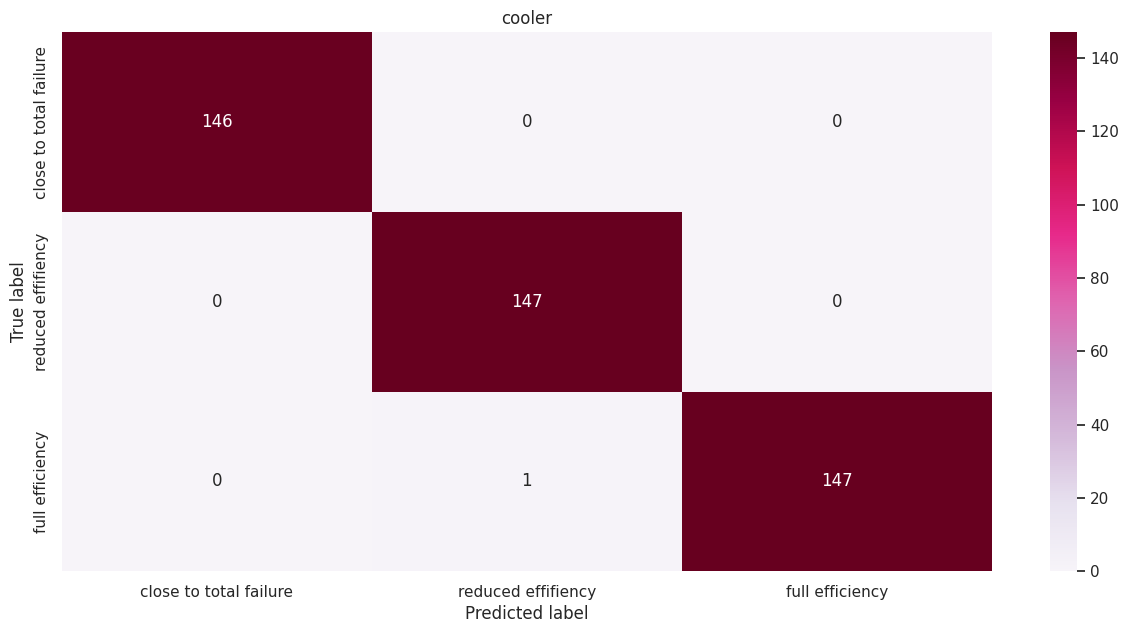

In [ ]:
draw_confusion(y_true[3],y_pred[3],predict_labels[3],labels[3], colors[3])


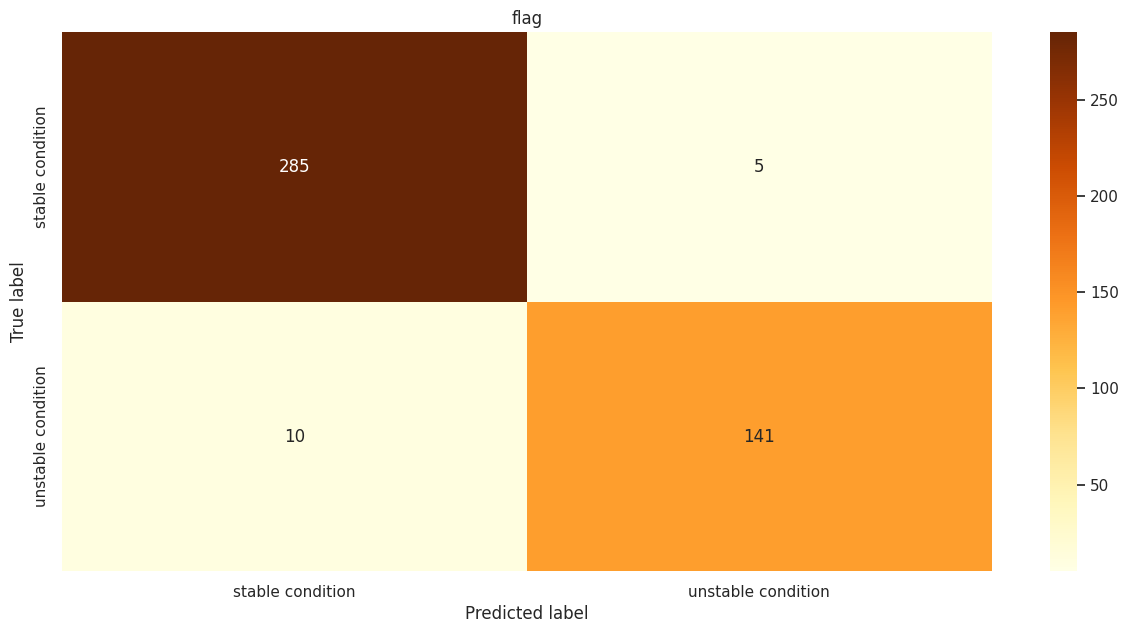

In [ ]:
draw_confusion(y_true[4],y_pred[4],predict_labels[4],labels[4], colors[4])
